### Exercise 64, 65 and 66

#### Import

In [1]:
import numpy as np
import numba as nb
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

#### Parameters

In [2]:
a, b = .5, 50
S = 10_000
sigmas = np.array([.1, 1.0, 100.0])

# Plotting
mplot = 200
space = np.linspace(2, 10, mplot)

#### Data

In [3]:
y = np.array([6, 8, 7, 6, 7, 4, 11, 8, 6, 3]).astype('int64')
n = len(y)

#### Functions

In [4]:
@nb.njit(nb.float64(nb.float64, nb.int64[:], nb.int64))
def get_log_likelihood(theta, y, n):
    result = 0
    for i in range(n):
        result += y[i] * np.log(theta) - theta
    return result


@nb.njit(nb.float64[:](nb.int64, nb.float64, nb.float64, nb.float64,
                      nb.int64[:], nb.int64))
def get_MH_sample(S, sigma, a, b, y, n):
    sample = np.zeros(S)
    
    for s in range(S):
        if s == 0:
            sample[s] = a + (b - a) * np.random.random()
            continue
        else:
            current = sample[s - 1]
            proposed = current + sigma*np.random.randn()
            
            if proposed < a or proposed > b:
                sample[s] = current
                continue
            
            # Prior is constant, so can ignore it
            
            loglik_current = get_log_likelihood(current, y, n)
            loglik_proposed = get_log_likelihood(proposed, y, n)
            
            log_acceptance_prob = loglik_proposed - loglik_current
            
            U = np.random.random()
            
            if np.log(U) < log_acceptance_prob:
                sample[s] = proposed
            else:
                sample[s] = current
    return sample

#### Run MCMC

In [5]:
samples = np.zeros((3, S))

for j in range(3):
    samples[j] = get_MH_sample(S, sigmas[j], a, b, y, n)

In [6]:
samples[0]

array([29.16694855, 29.16694855, 29.13590883, ...,  6.76258838,
        6.79396266,  6.79692822])

#### Trace plots

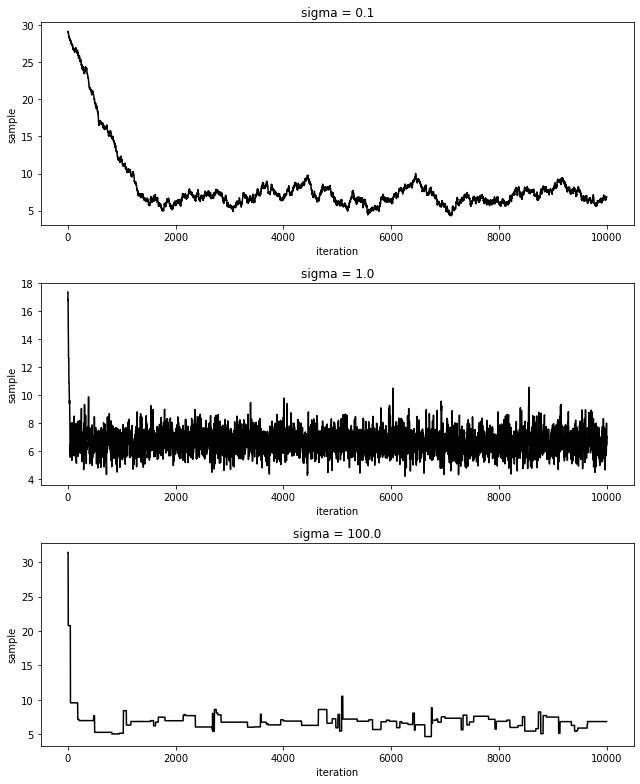

In [7]:
fig, axs = plt.subplots(3, 1, figsize=(9, 11))

for j in range(3):
    axs[j].plot(np.arange(S), samples[j], color='black')
    axs[j].set_xlabel('iteration')
    axs[j].set_ylabel('sample')
    axs[j].set_title(f'sigma = {sigmas[j]}')
plt.tight_layout()
plt.show()

#### Autocorrelation

#### Without burn-in

In [8]:
fig, axs = plt.subplots(3, 1, figsize=(9, 11))

for j in range(3):
    sample = samples[j]
    fhat = np.mean(sample)
    sigmasq = np.var(sample, ddof=1)
    gamma = np.zeros(S)
    for s in range(S):
        gamma[s] = np.sum((sample[:S-s] - fhat) * (sample[s:] - fhat)) / n
    rho = gamma / gamma[0]
    
    axs[j].plot(np.arange(S), rho, color='black')
    axs[j].set_xlabel('iteration')
    axs[j].set_ylabel('autocorrelation')
    axs[j].set_title(f'sigma = {sigmas[j]}')
plt.tight_layout()
plt.show()

#### With burn-in

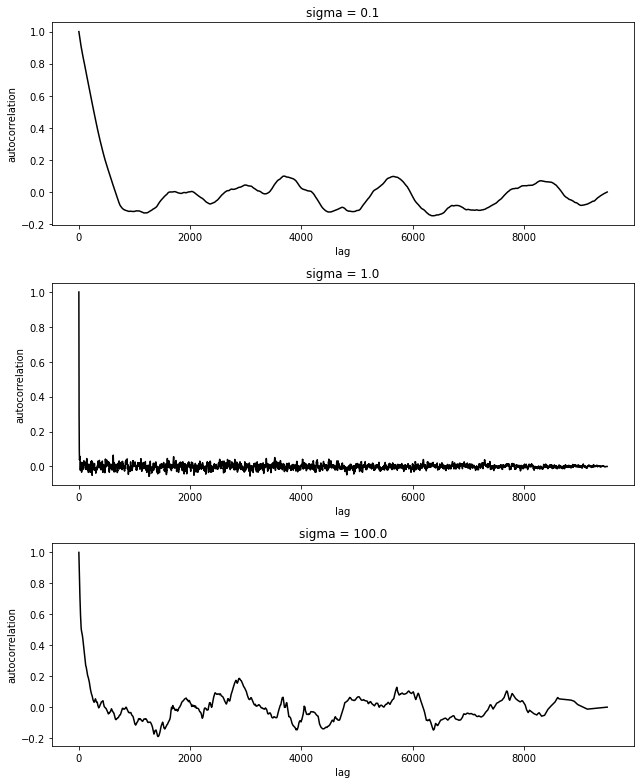

In [9]:
samples = samples[:, int(S//20):]
S = len(samples[0])

fig, axs = plt.subplots(3, 1, figsize=(9, 11))

for j in range(3):
    sample = samples[j]
    fhat = np.mean(sample)
    sigmasq = np.var(sample, ddof=1)
    gamma = np.zeros(S)
    for s in range(S):
        gamma[s] = np.sum((sample[:S-s] - fhat) * (sample[s:] - fhat)) / n
    rho = gamma / gamma[0]
    
    axs[j].plot(np.arange(S), rho, color='black')
    axs[j].set_xlabel('lag')
    axs[j].set_ylabel('autocorrelation')
    axs[j].set_title(f'sigma = {sigmas[j]}')
plt.tight_layout()
plt.show()

#### Effective sample size

In [10]:
for j in range(3):
    sample = samples[j]
    fhat = np.mean(sample)
    sigmasq = np.var(sample, ddof=1)
    gamma = np.zeros(S)
    for s in range(S):
        gamma[s] = np.sum((sample[:S-s] - fhat) * (sample[s:] - fhat)) / n
    rho = gamma / gamma[0]

    varfhat = sigmasq / S * (1 + 2 * np.sum((1 - np.arange(1, S) / S) * rho[:-1]))
    ESS = sigmasq / varfhat
    print(f'ESS  = {np.round(ESS, 2)} when sigma = {sigmas[j]}')

ESS  = 34.07 when sigma = 0.1
ESS  = 1987.88 when sigma = 1.0
ESS  = 255.12 when sigma = 100.0


#### With tensorflow_probability

In [11]:
for j in range(3):
    ESS = tfp.mcmc.effective_sample_size(samples[j])
    print(f'ESS  = {np.round(ESS, 2)} when sigma = {sigmas[j]}')

C:\python310\lib\site-packages\tensorflow_probability\python\__init__.py:70: UserWarning: TensorFloat-32 matmul/conv are enabled for NVIDIA Ampere+ GPUs. The resulting loss of precision may hinder MCMC convergence. To turn off, run `tf.config.experimental.enable_tensor_float_32_execution(False)`. For more detail, see https://github.com/tensorflow/community/pull/287.
  warnings.warn(


ESS  = 16.58 when sigma = 0.1
ESS  = 1276.84 when sigma = 1.0
ESS  = 55.42 when sigma = 100.0
